# About Dataset

The dataset is from a [DataCamp project](https://www.datacamp.com/projects/184) about an A/B test with a mobile game, Cookie Cats.

### Column Desc

| Column         | Type     | Desc                                                                                  |
|----------------|----------|---------------------------------------------------------------------------------------|
| userid         | numeric  | A unique number that identifies each player                                           |
| version        | category | Whether the player was put in gate_30 or gate_40 group                                |
| sum_gamerounds | numeric  | The number of game rounds played by the player during the first 14 days after install |
| rentention_1   | boolean  | Did the player come back and play 1 days after installing?                            |
| retention_7    | boolean  | Did the player come back and play 7 days after installing?                            |

# AB Testing Process

1. Data & Problem Understanding
2. Handle missing value / outlier / unexpected values if detected
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
    - Check normality and homogeneity
    - Apply test (shapiro, levene-test, t-test, welch test, mann whitney u test)
5. Evaluate the results
6. Make inferences
7. Recommend business decision to customer / director / ceo etc.

# Packages

In [206]:
# base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
from collections import defaultdict 

# hypothesis testing
import scipy.stats as stats
from scipy.stats import shapiro

In [207]:
# other settings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:.4f}".format

# Data

In [208]:
df_path = "/kaggle/input/mobile-games-ab-testing/cookie_cats.csv"
df = pd.read_csv(df_path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [209]:
# check default data types

df_dtypes = defaultdict(dict)
for x in ["object", "integer", "float", "bool"]:
    col = df.select_dtypes(x).columns.tolist()
    df_dtypes[x]["col"] = col 
    df_dtypes[x]["total"] = len(col)

df_dtypes

defaultdict(dict,
            {'object': {'col': ['version'], 'total': 1},
             'integer': {'col': ['userid', 'sum_gamerounds'], 'total': 2},
             'float': {'col': [], 'total': 0},
             'bool': {'col': ['retention_1', 'retention_7'], 'total': 2}})

In [210]:
# is there any missing value?
df.isnull().values.any()

False

In [211]:
# memory usage
buf = io.StringIO()
df.info(buf=buf)
info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
info

'2.2+ MB'

# Summary

In [212]:
# is userid column has unique values?

n_unique = df["userid"].nunique()
print(n_unique == df.shape[0])
print(f"Unique user: {n_unique}")

True
Unique user: 90189


In [213]:
# The number of game rounds played by the player during the first 14 days after install

df.describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,1.0000,5.0000,16.0000,51.0000,134.0000,221.0000,493.0000,49854.0000


In [214]:
df.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


# Detect Extreme Values

Text(0.5, 1.0, 'Distribution of Two Groups')

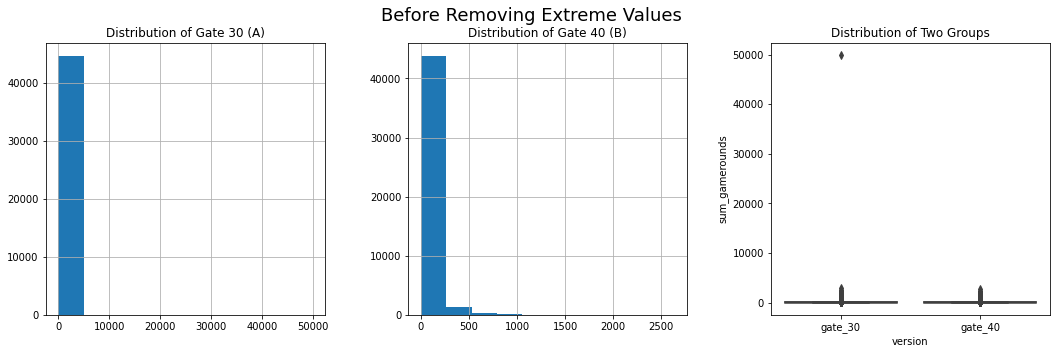

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df[df["version"] == "gate_30"].hist("sum_gamerounds", ax=axes[0])
df[df["version"] == "gate_40"].hist("sum_gamerounds", ax=axes[1])
sns.boxplot(x=df["version"], y=df["sum_gamerounds"], ax=axes[2])

plt.suptitle("Before Removing Extreme Values", fontsize=18)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize=12)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize=12)
axes[2].set_title("Distribution of Two Groups", fontsize=12)


In [216]:
df.sort_values(by="sum_gamerounds", ascending=False)[["sum_gamerounds"]]

,sum_gamerounds
57702,49854
7912,2961
29417,2640
43671,2438
48188,2294
...,...
59687,0
23707,0
59670,0
59645,0


In [217]:
# remove extreme values
df = pd.read_csv(df_path)
df = df[df["sum_gamerounds"] < df["sum_gamerounds"].max()]
df.sort_values(by="sum_gamerounds", ascending=False)[["sum_gamerounds"]]

,sum_gamerounds
7912,2961
29417,2640
43671,2438
48188,2294
46344,2251
...,...
59687,0
23707,0
59670,0
59645,0


Text(0.5, 1.0, 'Distribution of Two Groups')

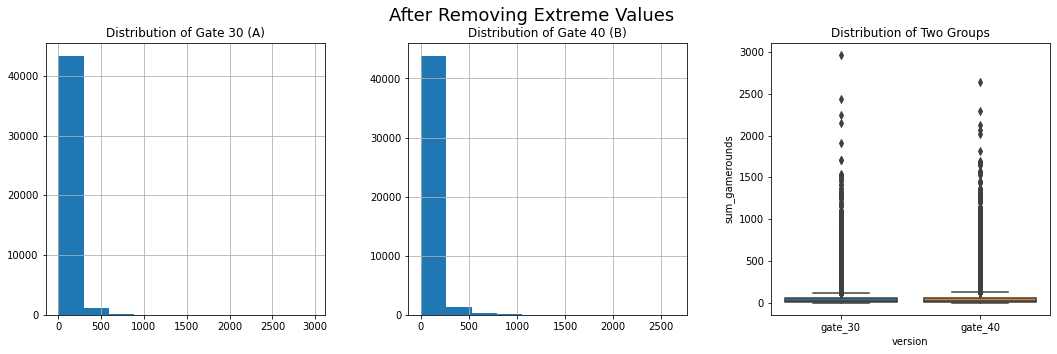

In [218]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df[df["version"] == "gate_30"].hist("sum_gamerounds", ax=axes[0])
df[df["version"] == "gate_40"].hist("sum_gamerounds", ax=axes[1])
sns.boxplot(x=df["version"], y=df["sum_gamerounds"], ax=axes[2])

plt.suptitle("After Removing Extreme Values", fontsize=18)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize=12)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize=12)
axes[2].set_title("Distribution of Two Groups", fontsize=12)


Text(0.5, 0.98, 'After Removing Extreme Value')

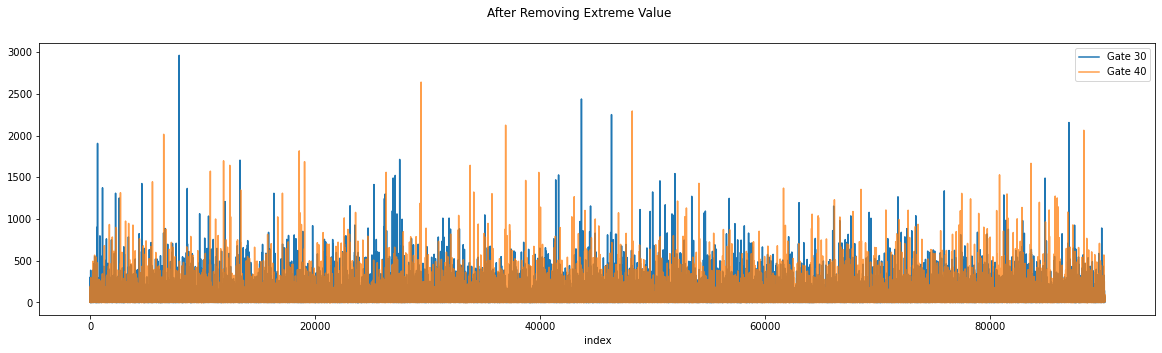

In [219]:
df[df["version"] == "gate_30"].reset_index().set_index("index")["sum_gamerounds"].plot(legend=True, label="Gate 30", figsize=(20, 5))
df[df["version"] == "gate_40"].reset_index().set_index("index")["sum_gamerounds"].plot(legend=True, label="Gate 40", alpha=0.75)

plt.suptitle("After Removing Extreme Value")

# Details

In [220]:
# n of user that never play the game
df[df["sum_gamerounds"] == 0].shape[0]

3994

The users installed the game, but 3994 users never played the game! Some reasons might explain this situation.

- They have no free time to play game
- Users might prefer to play other games or they play other games already
- Some user don't like the app

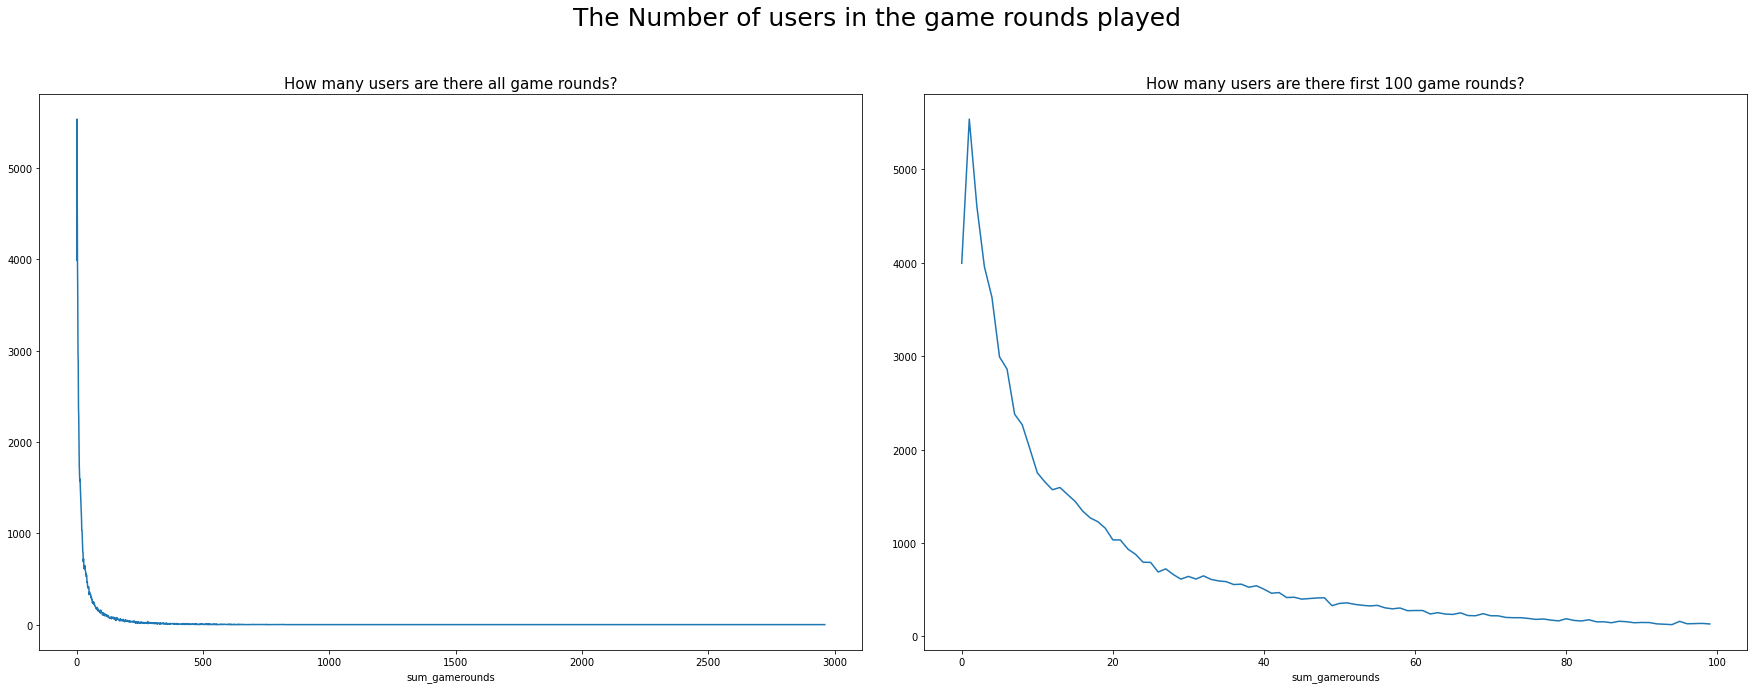

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
df.groupby("sum_gamerounds")["userid"].count().plot(ax=axes[0])
df.groupby("sum_gamerounds")["userid"].count()[:100].plot(ax=axes[1])

plt.suptitle("The Number of users in the game rounds played", fontsize=25)
axes[0].set_title("How many users are there all game rounds?", fontsize=15)
axes[1].set_title("How many users are there first 100 game rounds?", fontsize=15)
plt.tight_layout(pad=3)

#### How many users reached gate 30 & 40 levels?

In [222]:
df.groupby("sum_gamerounds")["userid"].count().loc[[30, 40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Looking at the summary statistics, the control and test groups seem similar, but are the two groups statistically siginificant?

In [223]:
df.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


#### Retention variables

- `retention_1` - did the player come back and play 1 day after intalling?
- `retention_7` - did the player come back and play 7 day after intalling?

> Players tend to not to play the game. There are many players who quit the game

In [224]:
pd.DataFrame({
    "Retention 1 Count" : df["retention_1"].value_counts(),
    "Retention 7 Count" : df["retention_7"].value_counts(),
    "Retention 1 Ratio" : df["retention_1"].value_counts() / len(df),
    "Retention 7 Ratio" : df["retention_7"].value_counts() / len(df)
})

,Retention 1 Count,Retention 7 Count,Retention 1 Ratio,Retention 7 Ratio
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


- 55% of the players didn't play the game 1 day after installing
- 81% of the players didn't play the game 7 day after installing

In [225]:
df.groupby(["version", "retention_1"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [226]:
df.groupby(["version", "retention_7"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

> There are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference

#### Retention

In [227]:
df["Retention"] = np.where((df["retention_1"] == True) & (df["retention_7"] == True), 1, 0)
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,gate_30,3,False,False,0
1,337,gate_30,38,True,False,0
2,377,gate_40,165,True,False,0
3,483,gate_40,1,False,False,0
4,488,gate_40,179,True,True,1
5,540,gate_40,187,True,True,1
6,1066,gate_30,0,False,False,0
7,1444,gate_40,2,False,False,0
8,1574,gate_40,108,True,True,1
9,1587,gate_40,153,True,False,0


In [228]:
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

> Similar results are seen when the number of users who came and didn't come 1 day dan 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 

# Retention Summary

In [229]:
df["Retention Combination"] = list(map(lambda x, y: str(x) + "-" + str(y), df["retention_1"], df["retention_7"]))
df.groupby(["version", "Retention Combination"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,Retention Combination,count,median,mean,std,max
0,gate_30,False-False,22840,6.0000,11.8197,21.6426,981
1,gate_30,False-True,1825,43.0000,73.1693,93.2223,1072
2,gate_30,True-False,13358,33.0000,49.6945,58.1254,918
3,gate_30,True-True,6676,127.0000,183.8863,189.6264,2961
4,gate_40,False-False,23597,6.0000,11.9133,20.9010,547
5,gate_40,False-True,1773,47.0000,75.2611,94.4780,1241
6,gate_40,True-False,13613,32.0000,50.0255,60.9246,2640
7,gate_40,True-True,6506,133.0000,190.2824,194.2201,2294


# A/B Testing

#### Assumptions:
- Check normality
- If normal distribuiton, check homogeneity

#### Steps:
- Split and define control group & test group
- Apply shapiro test for normality
- If parametric, apply levene test for check homogeneity of variance
- If parametric + homogenity of variance -> Apply t-test
- If parametric - homogeneity of variance -> Apply welch test
- If non-parametric apply Mann Whitney U test directly

In [230]:
# define A/B groups

df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,Retention Combination
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [231]:
from scipy.stats import shapiro
import scipy.stats as stats

group = "version"
target = "sum_gamerounds"

groupA = df[df[group] == "A"][target]
groupB = df[df[group] == "B"][target]

In [233]:
# Normality Assumption, 
# H0: Fulfilled
# H1: Not Fultilled

ntA = shapiro(groupA)[1] < 0.05
ntB = shapiro(groupB)[1] < 0.05

if (ntA == False) & (ntB == False): # Normality Fulfilled, # Parametric Test
    # Assumption: Homogeneity of Variance
    # H0: homogeinety: False
    # H1: Heterogenerous: True
    leveneTest = stats.levene(groupA, groupB)[1] < 0.05
    
    if leveneTest == False:
        # Homogeneity
        # H0: M1 == M2: False
        # H1: M1 != M2: True
        ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
    else:
        # Heterogenous
        # H0: M1 == M2: False
        # H1: M1 != M2: True
        ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]

else: # Normality Violated, # Non-Parametric Test
    # H0: M1 == M2: False
    # H1: M1 != M2: True
    ttest = stats.mannwhitneyu(groupA, groupB)[1]
    print(f"running {ttest}")

running 0.05089155279145376


In [234]:
res = pd.DataFrame({
    "AB Hypothesis": [ttest < 0.05],
    "pvalue": [ttest]
})

res["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
res["AB Hypothesis"] = np.where(res["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
res["Comment"] = np.where(res["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar", "A/B groups are not similar")

if (ntA == False) & (ntB == False):
    res["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
    res = res[["Test Type", "Homogeneity", "AB Hypothesis", "pvalue", "Comment"]]
else:
    res = res[["Test Type", "AB Hypothesis", "pvalue", "Comment"]]
res

,Test Type,AB Hypothesis,pvalue,Comment
0,Non-Parametric,Fail to Reject H0,0.0509,A/B groups are similar
